# My solution to sales prediction competition: https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor

from pyod.models.copod import COPOD
from seaborn import heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")

In [125]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_sub = pd.DataFrame({"Item_Identifier" : data_test["Item_Identifier"], "Outlet_Identifier" : data_test["Outlet_Identifier"]}) # Submission data
data_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [126]:
print(f"""data_train shape
{data_train.shape}
data_test shape
{data_test.shape}""")

data_train shape
(8523, 12)
data_test shape
(5681, 11)


In [127]:
data_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [128]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Impute NaN

In [129]:
print(f"""data_train NaN
{data_train.isnull().mean() * 100}

data_test NaN
{data_test.isnull().mean() * 100}""")

data_train NaN
Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

data_test NaN
Item_Identifier               0.000000
Item_Weight                  17.180074
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.269671
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
dtype: float64


### Impute categorical data with most frequent

In [130]:
si = SimpleImputer(strategy="most_frequent")
data_train["Outlet_Size"] = si.fit_transform(pd.DataFrame(data=data_train["Outlet_Size"]))
data_test["Outlet_Size"] = si.transform(pd.DataFrame(data=data_test["Outlet_Size"]))

### Impute numerical data with KNN

In [131]:
knn = KNNImputer()
data_train["Item_Weight"] = knn.fit_transform(pd.DataFrame(data=data_train["Item_Weight"]))
data_test["Item_Weight"] = knn.transform(pd.DataFrame(data=data_test["Item_Weight"]))

### Encode categorical data

In [132]:
def unique_ordinal(df_train, ordinal):
    for col in ordinal:
        print(f"Column: {col} ; Unique: {df_train[col].unique()}")

### All unique values in ordinal categorical columns

In [133]:
nominal = ["Item_Identifier", "Item_Type", "Outlet_Identifier", "Outlet_Type"]
ordinal = ["Item_Fat_Content", "Outlet_Size", "Outlet_Location_Type"]
unique_ordinal(data_train, ordinal)

Column: Item_Fat_Content ; Unique: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Column: Outlet_Size ; Unique: ['Medium' 'High' 'Small']
Column: Outlet_Location_Type ; Unique: ['Tier 1' 'Tier 3' 'Tier 2']


In [134]:
def encode_nominal(df_train, df_test, nominal):
    df_train = pd.get_dummies(df_train, columns=nominal, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=nominal, drop_first=True)
    return df_train, df_test

In [135]:
def encode_ordinal(df_train, df_test, ordinal):
    df_train[ordinal[0]] = df_train[ordinal[0]].replace({"low fat" : "Low Fat", "LF" : "Low Fat", "reg" : "Regular"}).replace({"Low Fat" : 0, "Regular" : 1})
    df_train[ordinal[1]] = df_train[ordinal[1]].replace({"Small" : 0, "Medium" : 1, "High" : 2})
    df_train[ordinal[2]] = df_train[ordinal[2]].replace({"Tier 1" : 0, "Tier 2" : 1, "Tier 3" : 2})
    df_test[ordinal[0]] = df_test[ordinal[0]].replace({"low fat" : "Low Fat", "LF" : "Low Fat", "reg" : "Regular"}).replace({"Low Fat" : 0, "Regular" : 1})
    df_test[ordinal[1]] = df_test[ordinal[1]].replace({"Small" : 0, "Medium" : 1, "High" : 2})
    df_test[ordinal[2]] = df_test[ordinal[2]].replace({"Tier 1" : 0, "Tier 2" : 1, "Tier 3" : 2})
    return df_train, df_test

In [136]:
def cat_to_int(df_train, df_test, cat):
    for col in (nominal + ordinal): 
        if col in data_train:
            data_train[col] = data_train[col].astype(int)
            data_test[col] = data_test[col].astype(int)
    return df_train, df_test

In [137]:
data_train, data_test = encode_nominal(data_train, data_test, nominal)
data_train, data_test = encode_ordinal(data_train, data_test, ordinal)
data_train, data_test = cat_to_int(data_train, data_test, (nominal + ordinal))
data_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Identifier_DRA24,Item_Identifier_DRA59,...,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,249.8092,1999,1,0,3735.1380,0,0,...,0,0,0,0,0,0,1,1,0,0
1,5.92,1,0.019278,48.2692,2009,1,2,443.4228,0,0,...,1,0,0,0,0,0,0,0,1,0
2,17.50,0,0.016760,141.6180,1999,1,0,2097.2700,0,0,...,0,0,0,0,0,0,1,1,0,0
3,19.20,1,0.000000,182.0950,1998,1,2,732.3800,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1987,2,2,994.7052,0,0,...,0,0,0,0,0,0,0,1,0,0


### Separate target labels

In [138]:
y_temp = data_train["Item_Outlet_Sales"]
data_train = data_train[data_test.columns] # Remove columns from data_train which are not in data_test
data_train["Item_Outlet_Sales"] = y_temp

### Exploring a bit

### Spotting correlations, outliers etc with scatterplotting features against target (non categorical)

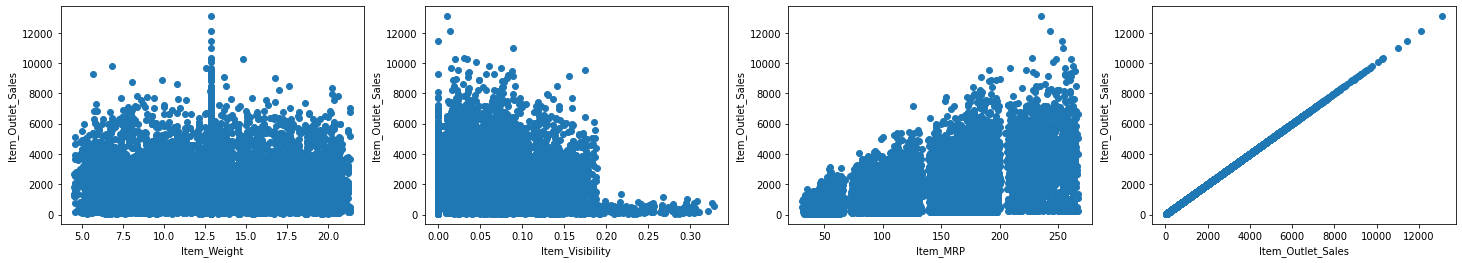

In [139]:
fix, axes = plt.subplots(1, 4, figsize=(25, 4))
r_idx = 0
for col in data_train.select_dtypes(include=[float]):
    axes[r_idx].scatter(data_train[col], data_train["Item_Outlet_Sales"])
    axes[r_idx].set_xlabel(col)
    axes[r_idx].set_ylabel("Item_Outlet_Sales")
    r_idx += 1

### Checking distributions with histograms

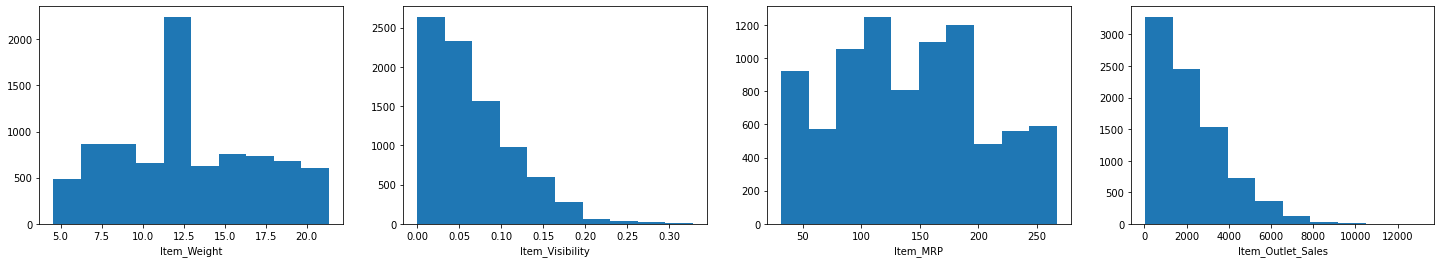

In [140]:
fix, axes = plt.subplots(1, 4, figsize=(25, 4))
r_idx = 0
for col in data_train.select_dtypes(include=[float]):
    axes[r_idx].hist(data_train[col])
    axes[r_idx].set_xlabel(col)
    r_idx += 1

### Checking for correlations. There are too many features to visualize this correlation matrix so we will just show a small part of it.

In [141]:
corr_mat = data_train.corr().abs().round(2)
corr_mat.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,...,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
Item_Weight,1.00,0.02,0.01,0.02,0.01,0.01,0.00,0.03,0.02,0.02,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01
Item_Fat_Content,0.02,1.00,0.05,0.01,0.00,0.00,0.00,0.04,0.04,0.01,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.02
Item_Visibility,0.01,0.05,1.00,0.00,0.07,0.07,0.03,0.01,0.04,0.01,...,0.21,0.05,0.03,0.04,0.04,0.04,0.14,0.03,0.05,0.13
Item_MRP,0.02,0.01,0.00,1.00,0.01,0.01,0.00,0.01,0.02,0.01,...,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.57
Outlet_Establishment_Year,0.01,0.00,0.07,0.01,1.00,0.19,0.09,0.01,0.01,0.02,...,0.39,0.54,0.26,0.17,0.03,0.05,0.25,0.47,0.54,0.05


### Drop any features with correlation above the threshold

In [142]:
threshold = 0.95
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
data_train.drop(to_drop, axis=1, inplace=True)
data_test.drop(to_drop, axis=1, inplace=True)
print(to_drop)

['Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']


### Find outliers

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    4.8s remaining:   24.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    5.6s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:    0.8s remaining:    4.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    1.5s finished


array([[<AxesSubplot:title={'center':'outlier_score'}>]], dtype=object)

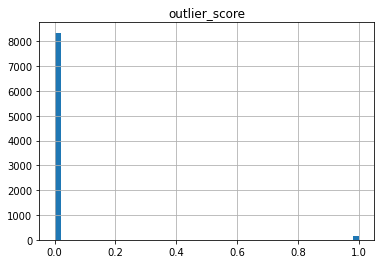

In [143]:
out_clf = COPOD(n_jobs=-1, contamination=0.02) # Top 2% of outliers
out_clf.fit(data_train)
out_df = pd.DataFrame({"outlier_score" : out_clf.predict(data_train)})
out_df.hist(bins=50)

In [144]:
data_train = data_train[out_df["outlier_score"] == 0] # Get rid of top outliers
data_train.reset_index(drop=True, inplace=True)

### Standardize data

In [145]:
data_train_y = data_train.pop("Item_Outlet_Sales")

In [146]:
ss = StandardScaler()
data_train = pd.DataFrame(data=ss.fit_transform(data_train), columns=data_train.columns)
data_test = pd.DataFrame(data=ss.transform(data_test), columns=data_test.columns)

### Model building

### Hyperparameter tuning

In [155]:
params = {
    "learning_rate" : [0.0275, 0.03, 0.0325],
    "num_iterations" : [175, 200, 225],
    "max_depth" : [3, 4, 5],
    "num_leaves" : [3, 7, 15]
}

gs = GridSearchCV(estimator=lgb.LGBMRegressor(n_jobs=-1, random_state=0), param_grid=params, cv=10, n_jobs=-1, scoring="neg_root_mean_squared_error")
gs.fit(data_train, data_train_y)

GridSearchCV(cv=10, estimator=LGBMRegressor(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.0275, 0.03, 0.0325],
                         'max_depth': [3, 4, 5],
                         'num_iterations': [175, 200, 225],
                         'num_leaves': [3, 7, 15]},
             scoring='neg_root_mean_squared_error')

In [156]:
print(f"""Best Params:
{gs.best_params_}
Best Score:
{gs.best_score_}""")

Best Params:
{'learning_rate': 0.0275, 'max_depth': 5, 'num_iterations': 200, 'num_leaves': 7}
Best Score:
-1038.867310032026


### Final model

In [157]:
reg_final = lgb.LGBMRegressor(**gs.best_params_, random_state=0)
reg_final.fit(data_train, data_train_y)

LGBMRegressor(learning_rate=0.0275, max_depth=5, num_iterations=200,
              num_leaves=7, random_state=0)

### Evalute model with cross validation score

In [158]:
print(f"""Mean Cross-Validation score:
{np.mean(cross_val_score(estimator=reg_final, X=data_train, y=data_train_y, cv=10, scoring="neg_root_mean_squared_error", n_jobs=-1))}""")

Mean Cross-Validation score:
-1038.867310032026


### Saving results

In [159]:
def greater_than_0(val):
    if val < 0:
        return 0
    return val

In [160]:
data_sub["Item_Outlet_Sales"] = reg_final.predict(data_test)
data_sub["Item_Outlet_Sales"] = data_sub["Item_Outlet_Sales"].apply(greater_than_0)
data_sub.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1539.944148
1,FDW14,OUT017,1402.023198
2,NCN55,OUT010,839.762335
3,FDQ58,OUT017,2485.543180
4,FDY38,OUT027,5142.527866


In [161]:
data_sub.to_csv("results.csv", index=False)

### Explain results

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

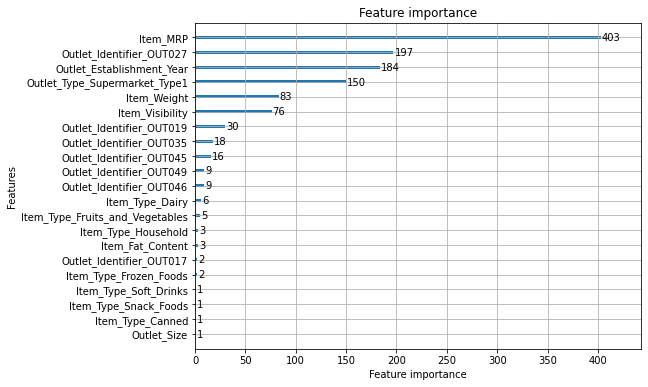

In [162]:
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(reg_final, ax=ax)